In [1]:
import numpy as np
import matplotlib.pyplot as pl

import scvelo as scv
scv.logging.print_version()

Running scvelo 0.1.24 (python 3.7.3) on 2019-10-28 18:26.


In [2]:
scv.settings.set_figure_params('scvelo', dpi_save=200, dpi=80, transparent=True)  # vectorized: pdf or svg
scv.settings.verbosity = 2

## Capturing non-stationary populations

computing neighbors
    finished (0:00:04)
computing velocities
    finished (0:00:00)
recovering dynamics
    finished (0:00:01)

outputs model fit of gene: 3


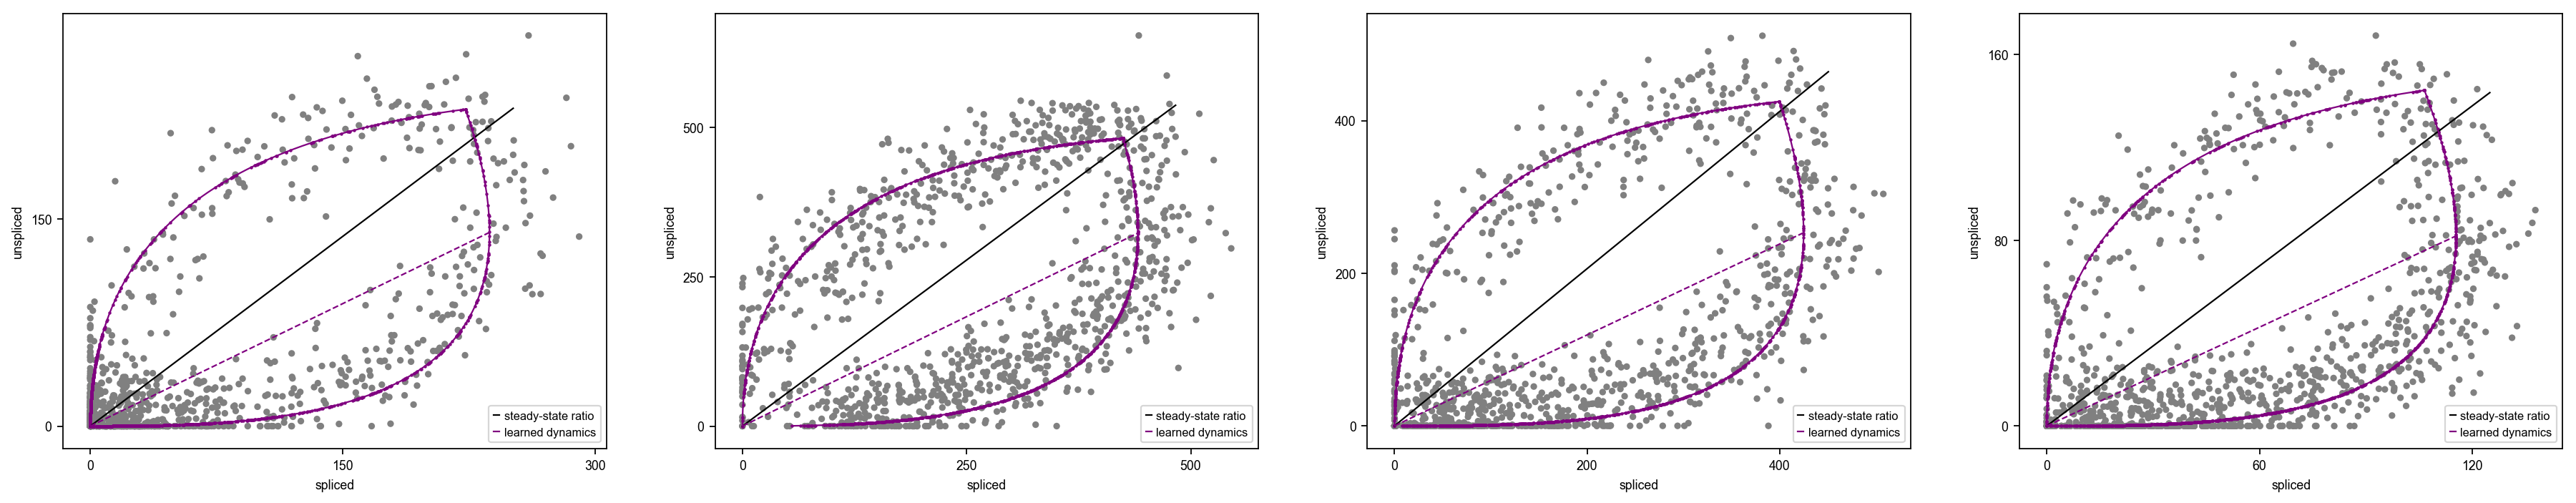

In [3]:
n_vars = 2000

mu = np.array([5, .2, .05])

R = np.array([[1., .2, .2], 
              [.2, 1., .8],
              [.2, .8, 1.]])

C = np.array([.4, .4, .4])[:, None]

cov = C.dot(C.T) * R

alpha, beta, gamma = np.exp(np.random.multivariate_normal(mu, cov, size=n_vars).T)  # multivariate log-normal
beta /= 3
gamma /= 3

# remove outliers
idx = (alpha < np.percentile(alpha, 99)) & (beta < np.percentile(beta, 99)) & (gamma < np.percentile(gamma, 99))
alpha = alpha[idx]
beta = beta[idx]
gamma = gamma[idx]
n_vars = np.sum(idx)

switches = np.random.uniform(.1, .5, size=n_vars)

adata = scv.datasets.simulation(n_obs=1000, t_max=20, n_vars=n_vars, switches=switches,
                                alpha=alpha, beta=beta, gamma=gamma, noise_level=.8)
# adata.var['switches'] = switches

scv.pp.neighbors(adata)
scv.tl.velocity(adata, mode='steady_state', use_raw=True)

var_names = adata.var_names[:4]
scv.tl.recover_dynamics(adata, var_names=var_names, max_iter=100)

scv.pl.scatter(adata, basis=var_names)

In [4]:
#adata.write('data/toy/Fig1_identifiability.h5ad')
adata = scv.read('data/toy/Fig1_identifiability.h5ad')

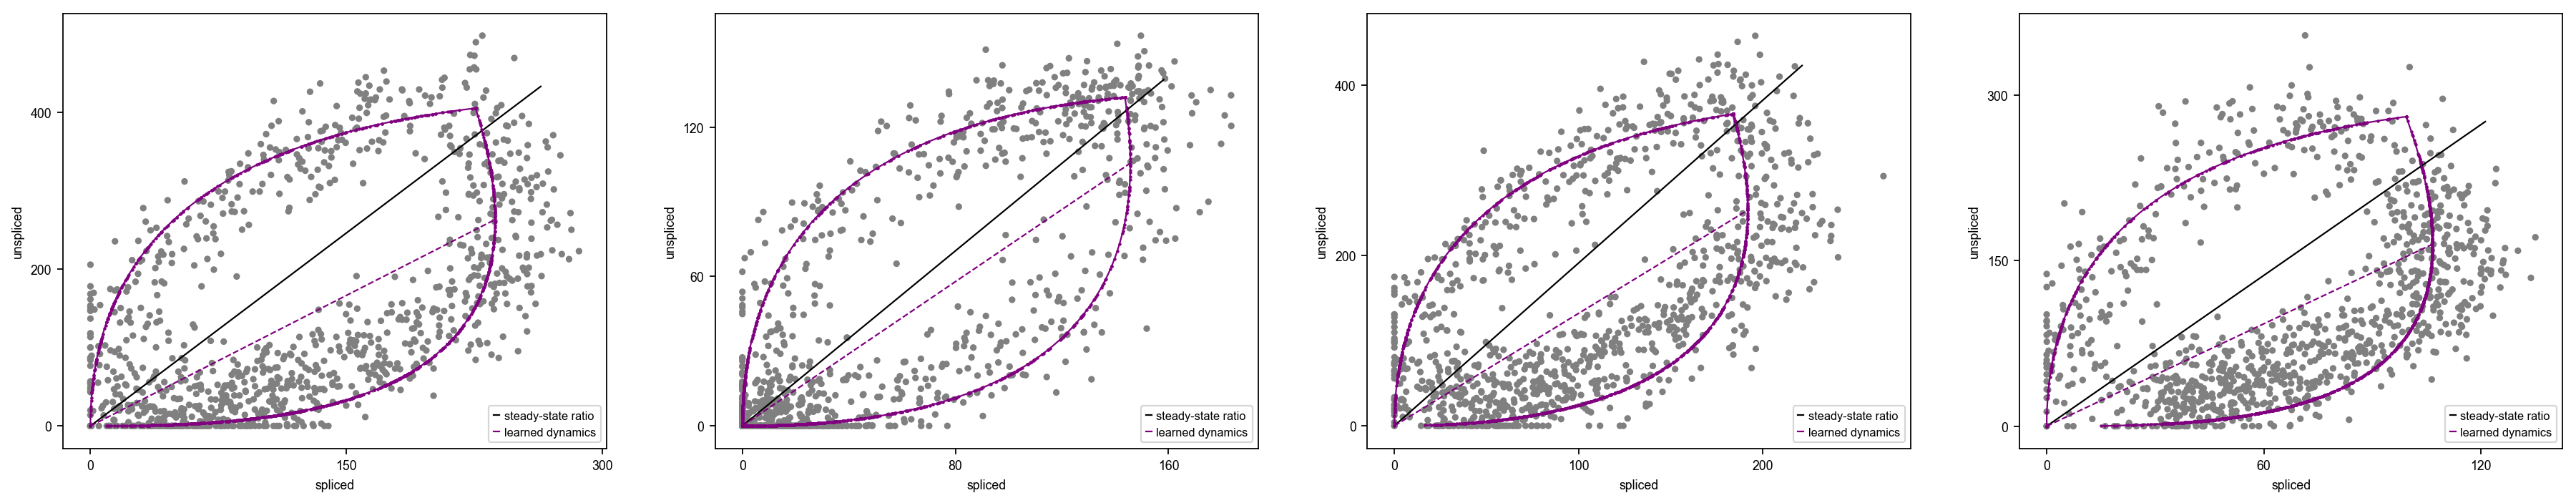

In [5]:
dm = scv.tl.recover_dynamics(adata, var_names='all', max_iter=100, use_raw=True)

var_names = adata.var_names[:4]
scv.pl.scatter(adata, basis=var_names, use_raw=True)

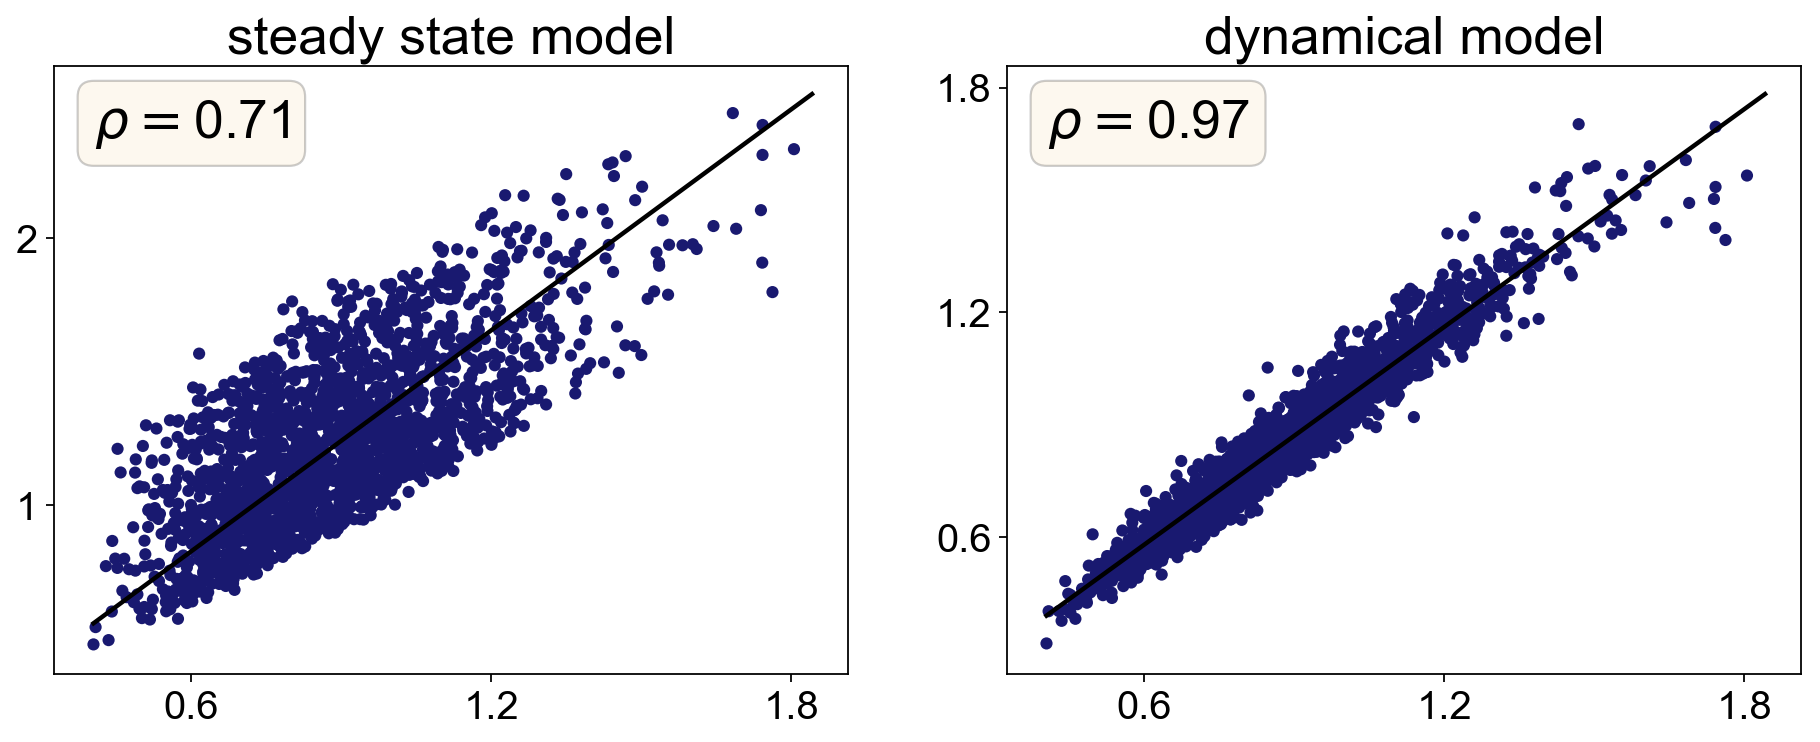

In [6]:
adata.var['true_ratio'] = np.array(adata.var.true_gamma / adata.var.true_beta)
adata.var['ss_ratio'] = np.array(adata.var.velocity_gamma)
adata.var['dm_ratio'] = np.array(adata.var.fit_gamma / adata.var.fit_beta)

xlabel = ylabel = ''
#xlabel, ylabel= None, 'est. ratio'

scv.pl.scatter(adata, 'true_ratio', ['ss_ratio', 'dm_ratio'], size=120, 
               xlabel=xlabel, ylabel=ylabel, title=['steady state model', 'dynamical model'], 
               show_linear_fit='k', fontsize=24, linewidth=2, color='midnightblue')

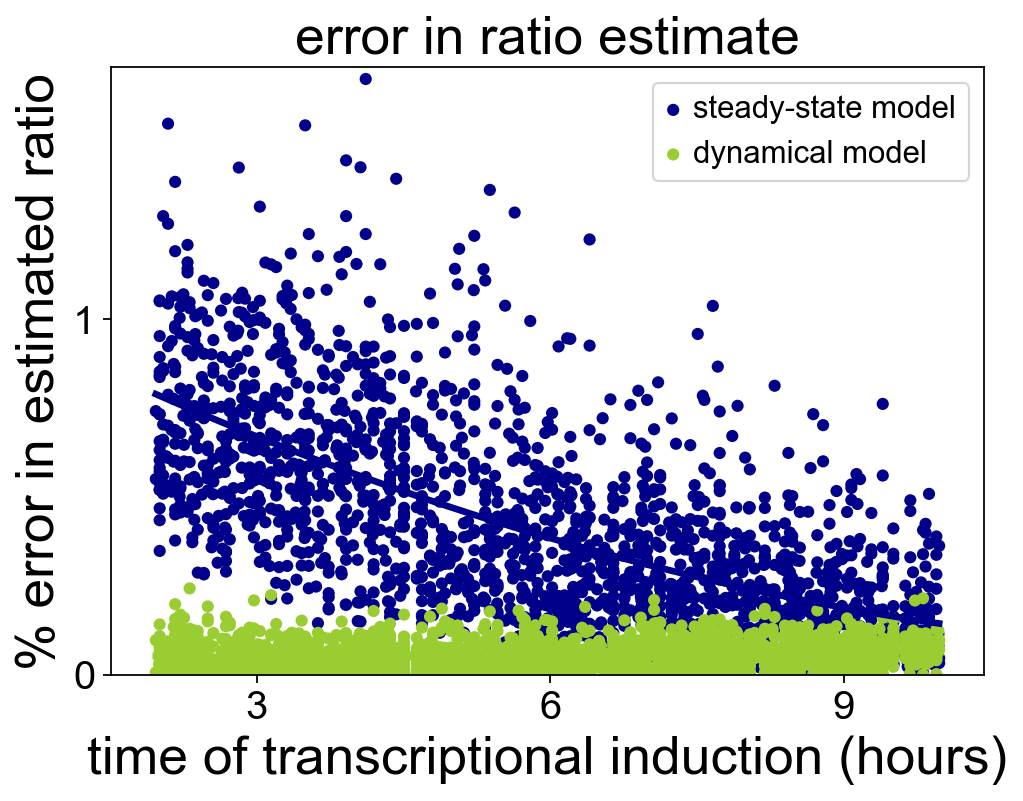

In [7]:
x = adata.var['true_t_'].values
true_ratio = adata.var['true_ratio']
y_ss = np.abs(adata.var['ss_ratio'] - true_ratio) / true_ratio
y_dm = np.abs(adata.var['dm_ratio'] - true_ratio) / true_ratio

ylim = [0, np.max([y_ss, y_dm]) * 1.02]

ax = scv.pl.scatter(adata, x, y_ss, color='darkblue', size=120, show=False,
                    show_polyfit=True, linewidth=3, label='steady-state model')

ax = scv.pl.scatter(adata, x, y_dm, ylim=ylim, color='yellowgreen', size=120, 
                    show=False, ax=ax, fontsize=24, 
                    xlabel='time of transcriptional induction (hours)',
                    ylabel='% error in estimated ratio', title='error in ratio estimate',
                    show_polyfit=True, linewidth=3, label='dynamical model')
ax.legend(loc='upper right', fontsize=14)

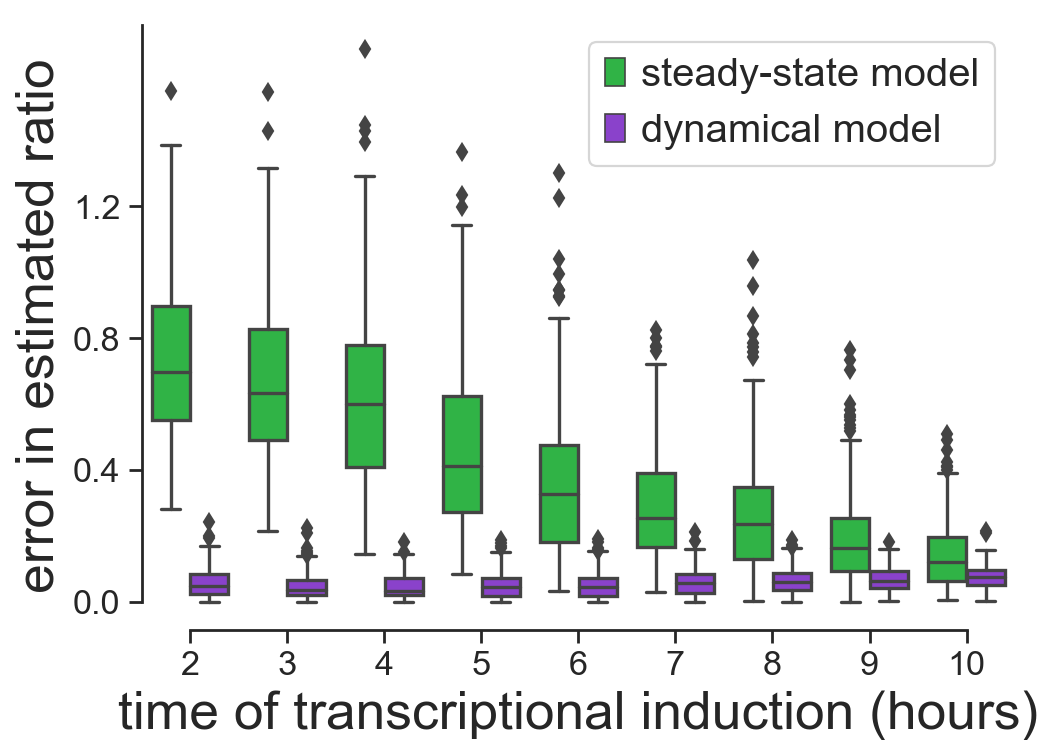

In [8]:
import pandas as pd
import seaborn as sns

data_ss = np.array([x, np.array(np.round(x), dtype=int), y_ss, np.repeat(False, len(y_ss))]).T
data_dm = np.array([x, np.array(np.round(x), dtype=int), y_dm, np.repeat(True, len(y_ss))]).T

data = pd.DataFrame(np.vstack([data_ss, data_dm]), columns=['time', 'x', 'error', 'model'])
data['x'] = np.array(data['x'], dtype=int)
data['model'] = np.array(data['model'], dtype=bool)

sns.set(style="ticks", palette="bright", font_scale=1.4)

ax = sns.boxplot(x="x", y="error", hue='model', palette=["g", "m"], data=data)
sns.despine(trim=True)

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["steady-state model", "dynamical model"], fontsize=18)

pl.ylabel("error in estimated ratio", fontsize=24)
pl.xlabel("time of transcriptional induction (hours)", fontsize=24)
pl.yticks(ticks=[0, 0.4, 0.8, 1.2]);

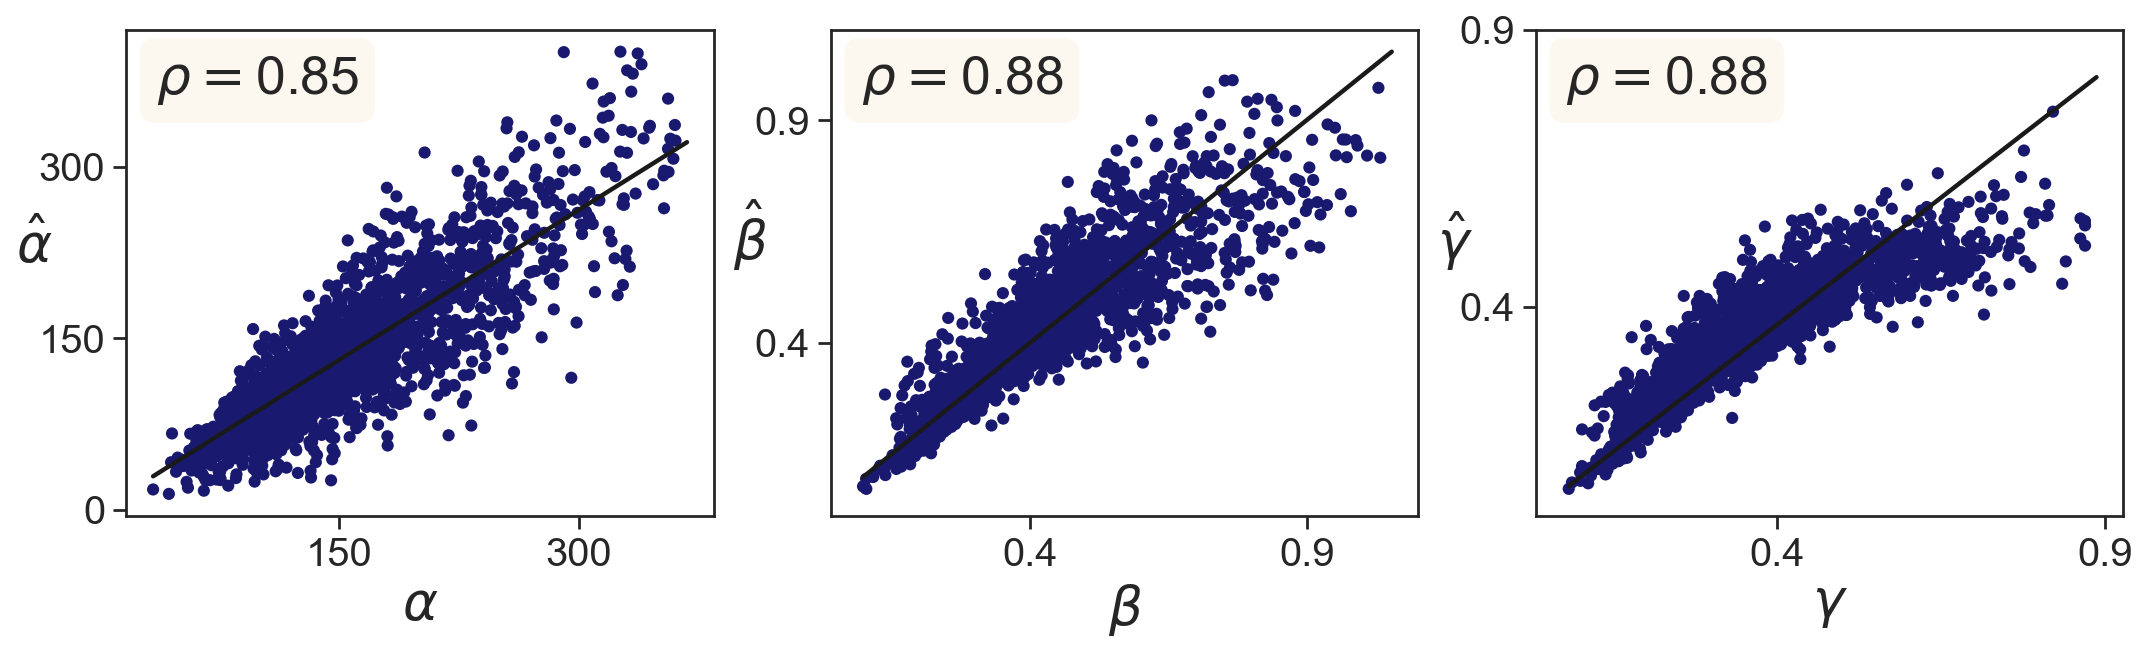

In [9]:
kwargs = {'show_linear_fit': 'k', 'size': 120, 'fontsize': 24, 
          'linewidth': 2, 'color': 'midnightblue', 'show': False}
fig, (ax1, ax2, ax3) = pl.subplots(1, 3, figsize=(16,4))
ax1 = scv.pl.scatter(adata, 'true_alpha', 'fit_alpha', ax=ax1,
                     xlabel=r'$\alpha$', ylabel=r'$\hat \alpha$', **kwargs)
ax2 = scv.pl.scatter(adata, 'true_beta', 'fit_beta', ax=ax2,
                     xlabel=r'$\beta$', ylabel=r'$\hat \beta$', **kwargs)
ax3 = scv.pl.scatter(adata, 'true_gamma', 'fit_gamma', ax=ax3, 
                     xlabel=r'$\gamma$', ylabel=r'$\hat \gamma$', **kwargs, )


ax2.set_xticks([.4, .9])
ax2.set_yticks([.4, .9])

ax3.set_xticks([.4, .9])
ax3.set_yticks([.4, .9])

ax1.yaxis.labelpad = 2
ax2.yaxis.labelpad = 2
ax3.yaxis.labelpad = 2

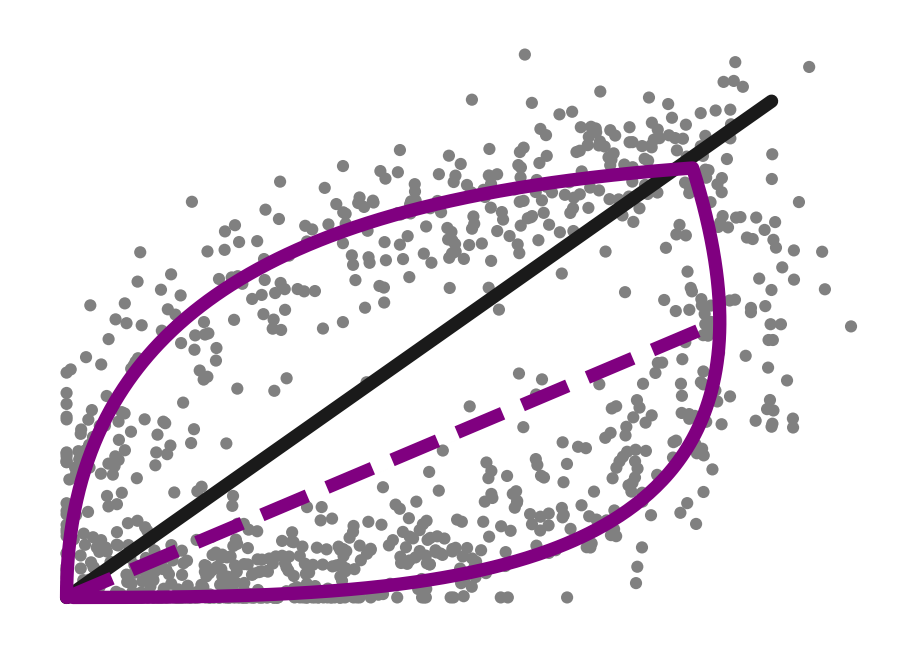

In [10]:
kwargs = {'use_raw': True, 'linewidth': 6, 'legend_fontsize': 14, 'color': 'grey', 'frameon': False, 'size': 120}
scv.pl.scatter(adata, basis='4', **kwargs, legend_loc='none')
#scv.pl.scatter(adata, basis='16', **kwargs, legend_loc='none',)

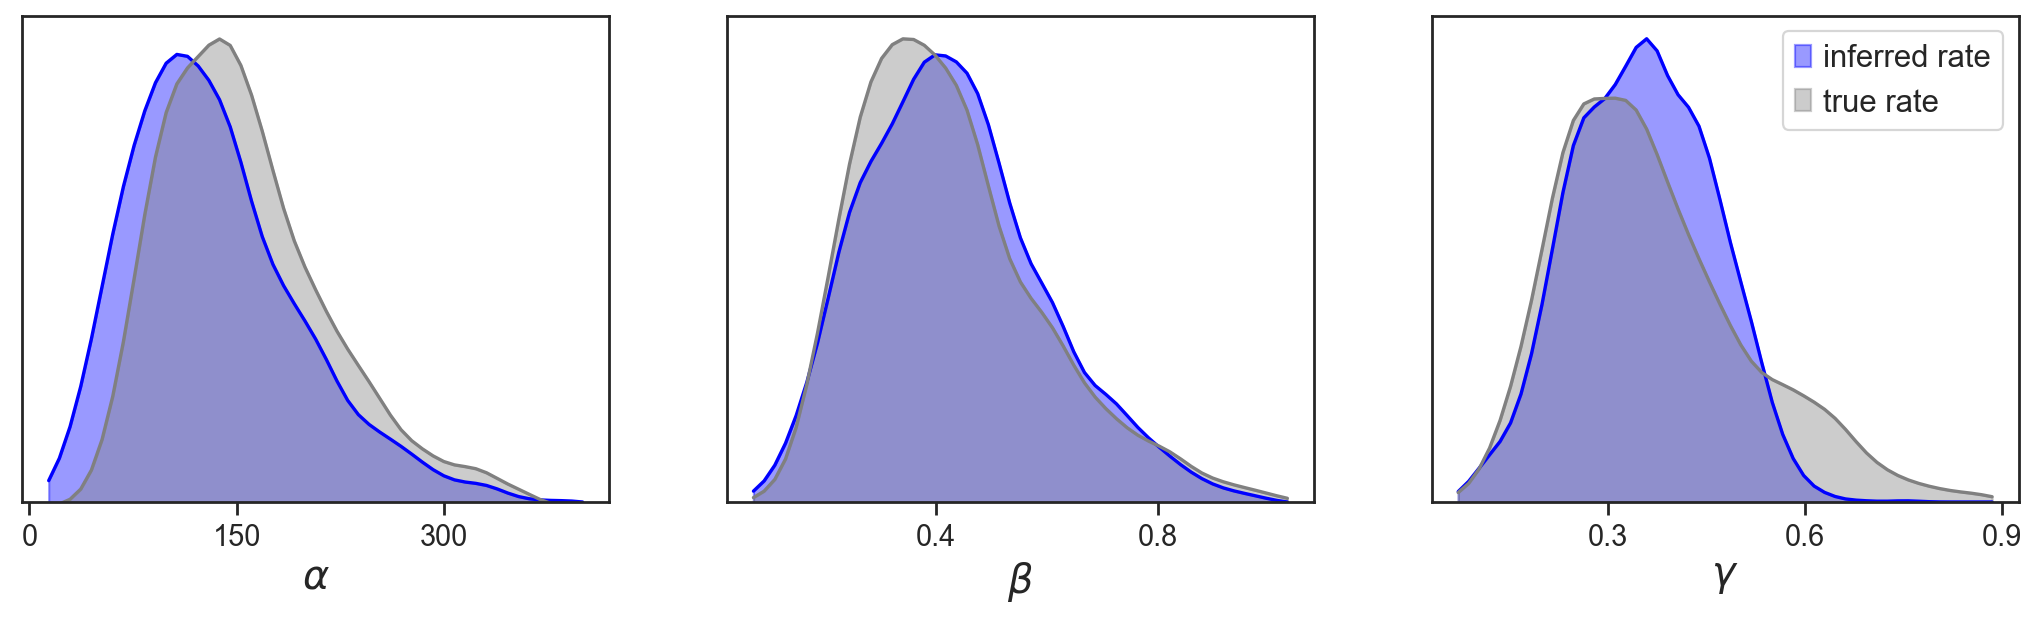

In [11]:
show_labels = True
if show_labels:
    labels = [None, None, ['inferred rate', 'true rate']]
    xlabels = [r'$\alpha$', r'$\beta$', r'$\gamma$']
else:
    labels = [None, None, None]
    xlabels = [None, None, None]

fig, (ax1, ax2, ax3) = pl.subplots(1, 3, figsize=(16,4))
ax1 = scv.pl.hist([adata.var['fit_alpha'], adata.var['true_alpha']], 
                  labels=labels[0], xlabel=xlabels[0],
                  colors=['blue', 'grey'], fontsize=18, legend_fontsize=14, kde=True, ax=ax1, show=False)

ax2 = scv.pl.hist([adata.var['fit_beta'], adata.var['true_beta']], 
                  labels=labels[1], colors=['blue', 'grey'], xlabel=xlabels[1],
                  fontsize=18, legend_fontsize=14, kde=True, ax=ax2, show=False)

ax3 = scv.pl.hist([adata.var['fit_gamma'], adata.var['true_gamma']], 
                  labels=labels[2], colors=['blue', 'grey'], xlabel=xlabels[2],
                  fontsize=18, legend_fontsize=14, kde=True, ax=ax3, show=False)

#ax1.set_xlabel('alpha')
ax1.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

if not show_labels:
    ax1.get_xaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax3.get_xaxis().set_visible(False)

computing moments based on connectivities
    finished (0:00:00)
computing velocities
    finished (0:00:00)
computing velocity graph
    finished (0:00:00)
computing terminal states
    identified 1 region of root cells and 1 region of end points 
    finished (0:00:00)


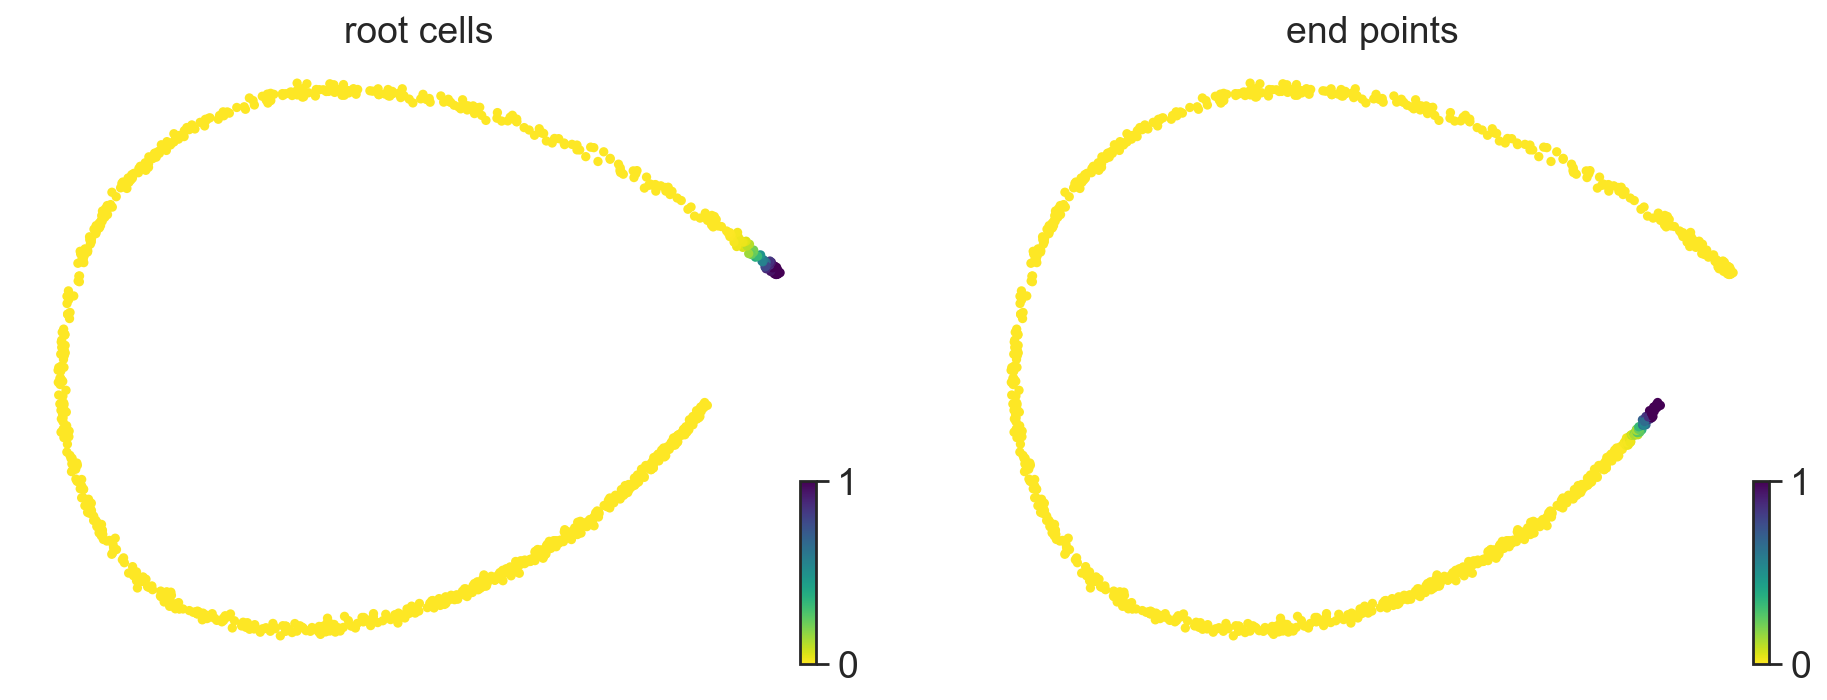

In [12]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)
scv.tl.terminal_states(adata)
scv.pl.scatter(adata, color=['root_cells', 'end_points'])

computing latent time
    finished (0:00:00)


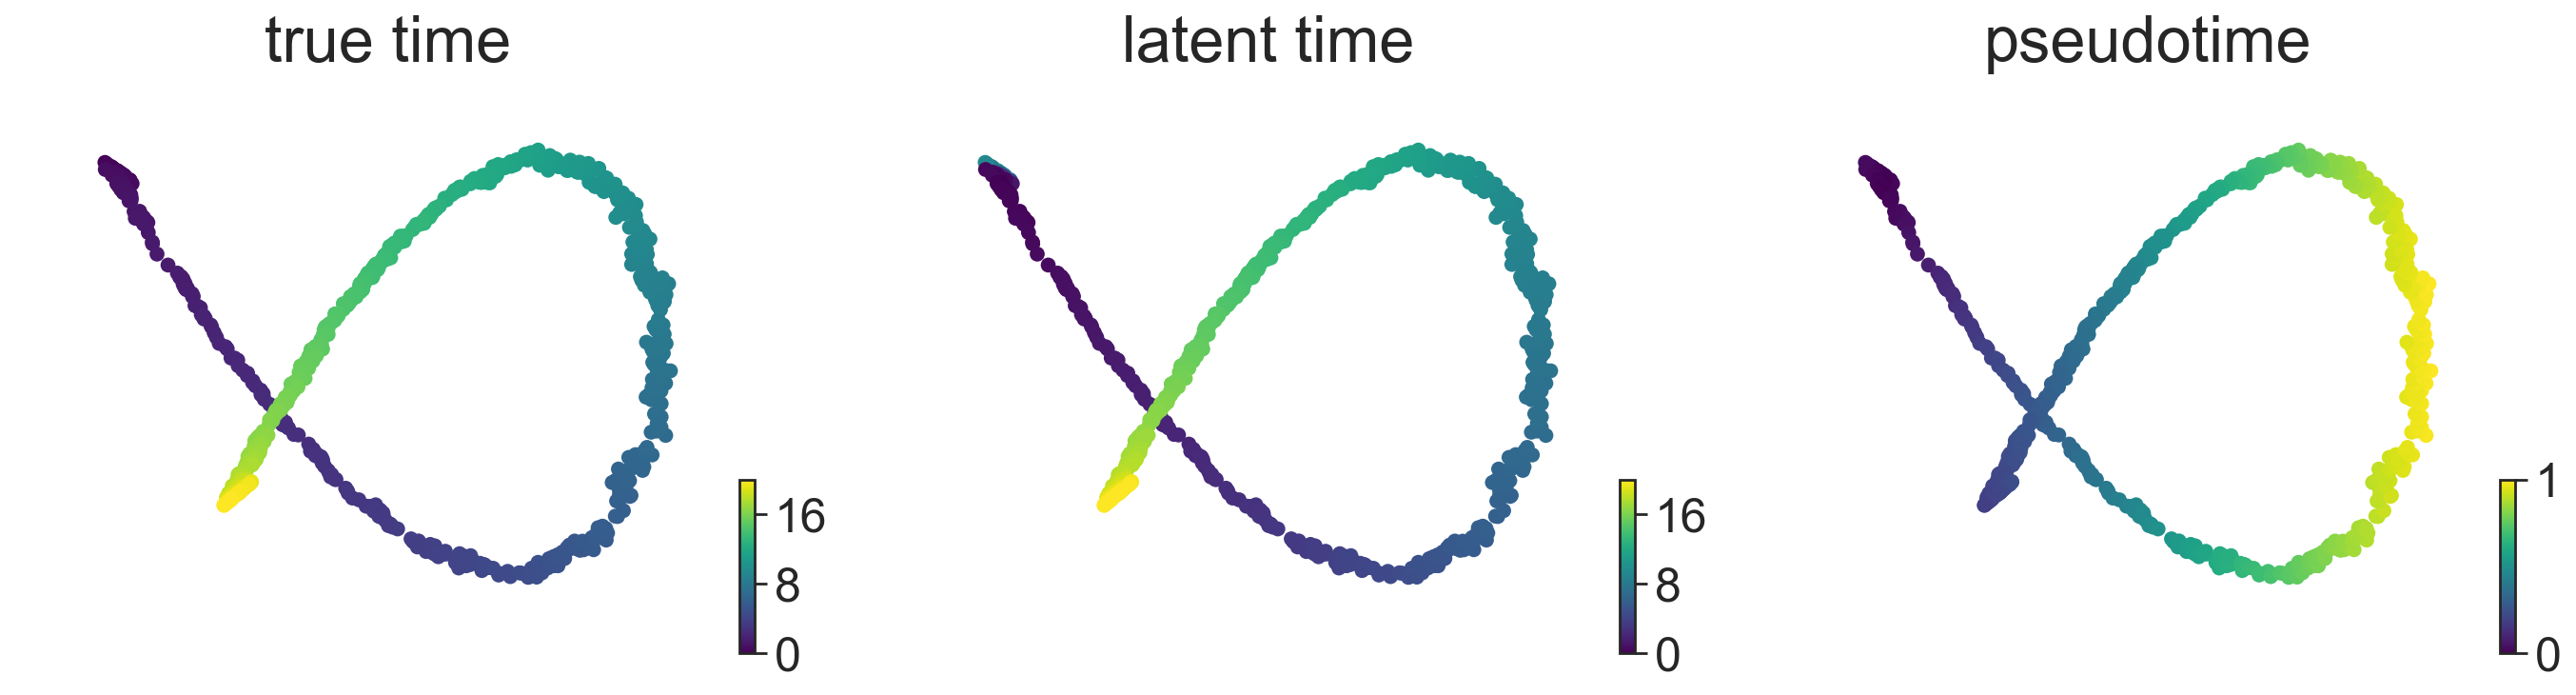

In [13]:
scv.tl.recover_latent_time(adata, t_max=20, min_confidence=.9)

adata.uns['iroot'] = 0

scv.tl.diffmap(adata)
scv.tl.dpt(adata)

scv.pl.scatter(adata, basis='diffmap', color=['true_t', 'latent_time', 'dpt_pseudotime'], 
               title=['true time', 'latent time', 'pseudotime'],
               fontsize=30, color_map='viridis', size=200, components='2,3')

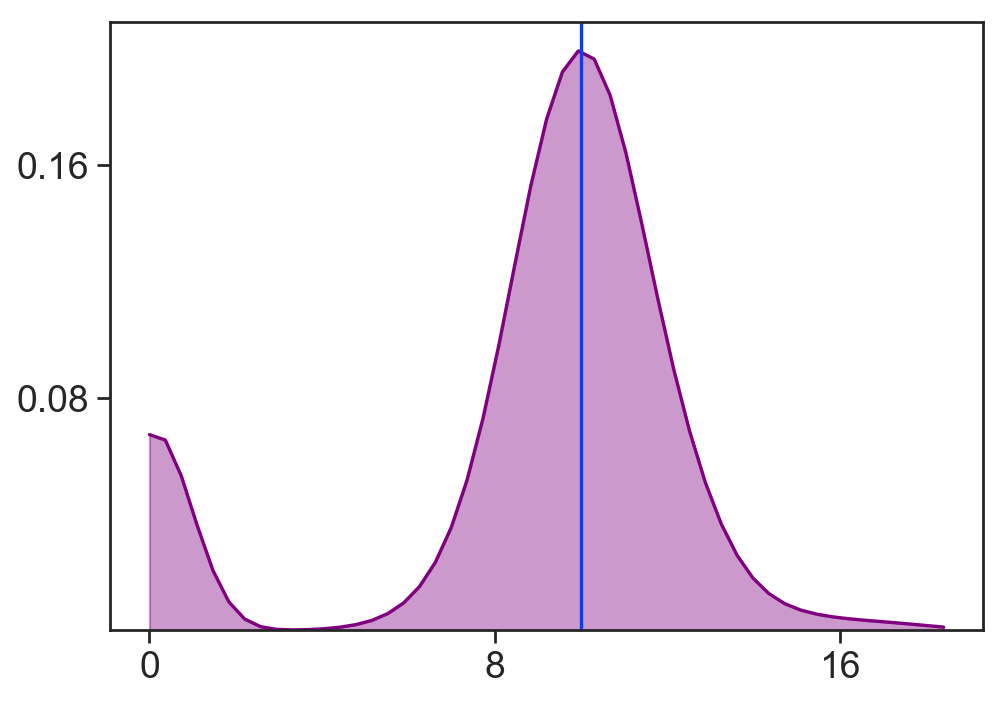

In [14]:
scv.pl.hist(adata.layers['fit_t'][700], kde=True, colors=['purple'], alpha=1, axvline=10, legend_fontsize=30)

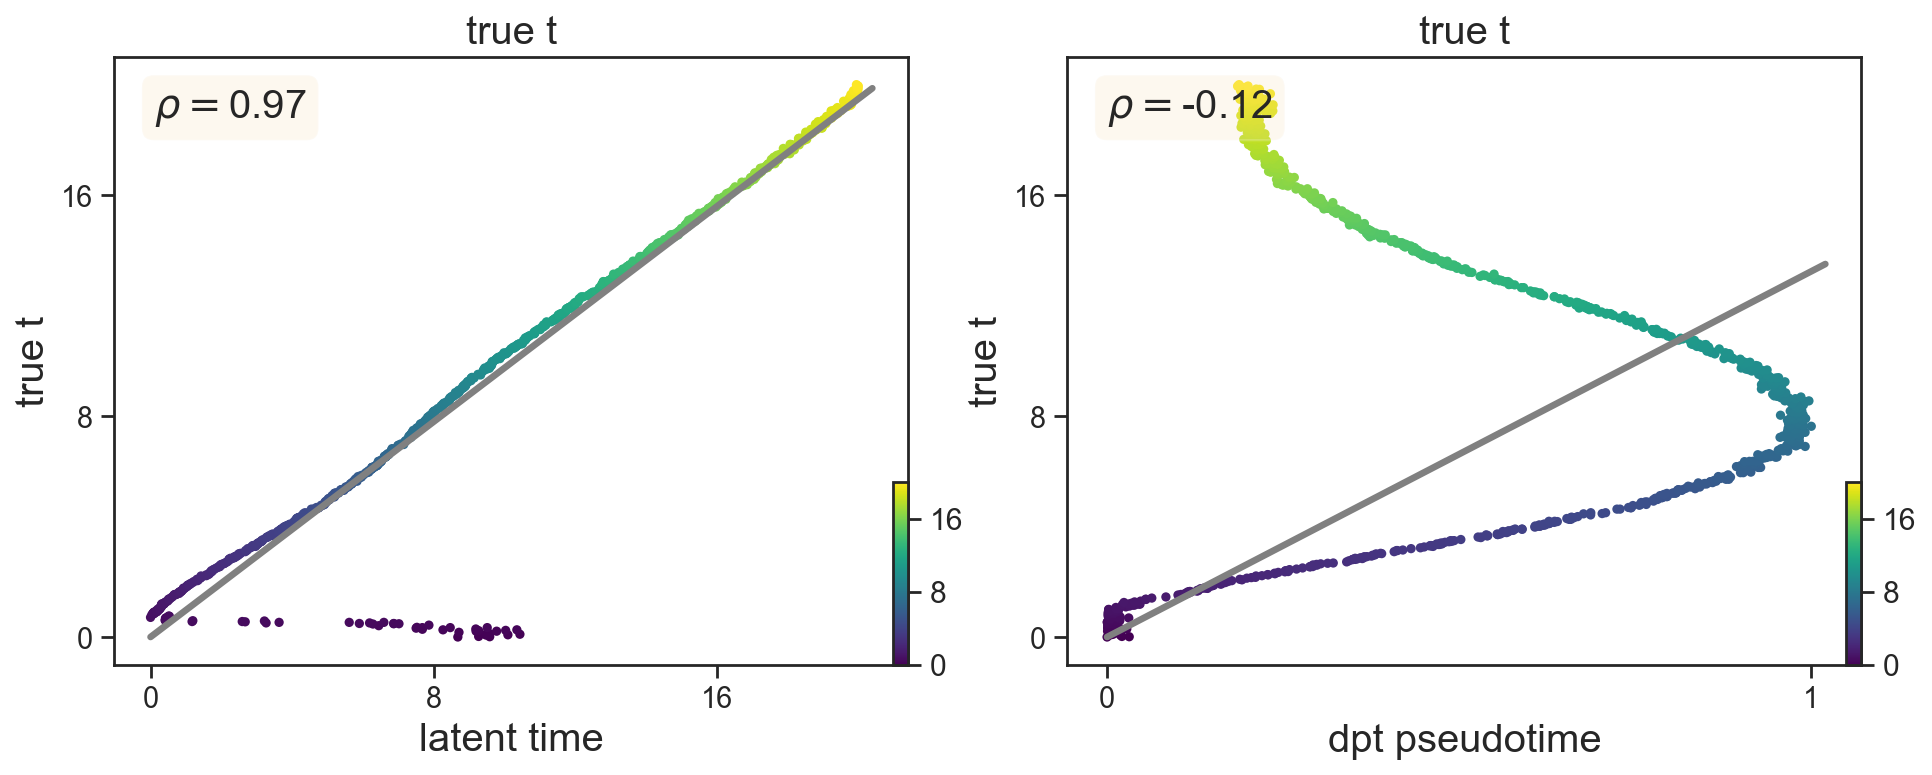

In [15]:
scv.pl.scatter(adata, ['latent_time', 'dpt_pseudotime'], 'true_t', 
               color='true_t', color_map='viridis', show_linear_fit=True, linewidth=3, fontsize=18)

In [16]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:01)
computing velocity graph
    finished (0:00:01)


computing velocity embedding
    finished (0:00:00)


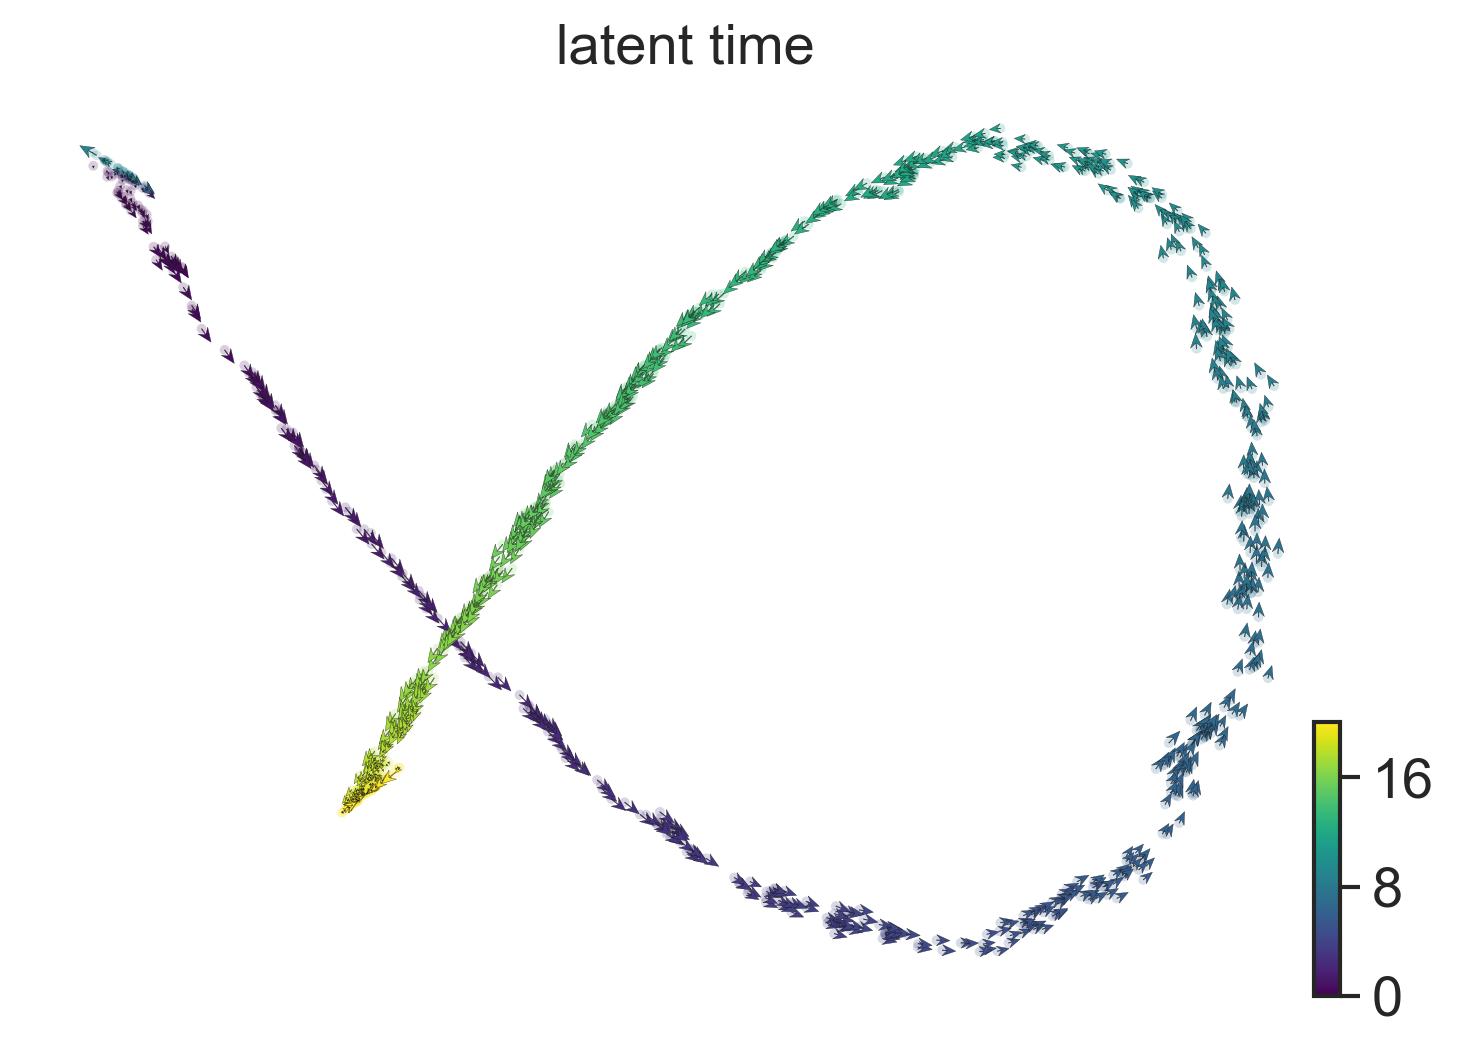

In [17]:
scv.pl.velocity_embedding(adata, basis='diffmap', components='2,3', 
                          arrow_size=1.8, arrow_length=2.5, dpi=120, 
                          color='latent_time', color_map='viridis')

# effect of varying kinetic rates

computing neighbors
    finished (0:00:00)
computing velocities
    finished (0:00:00)


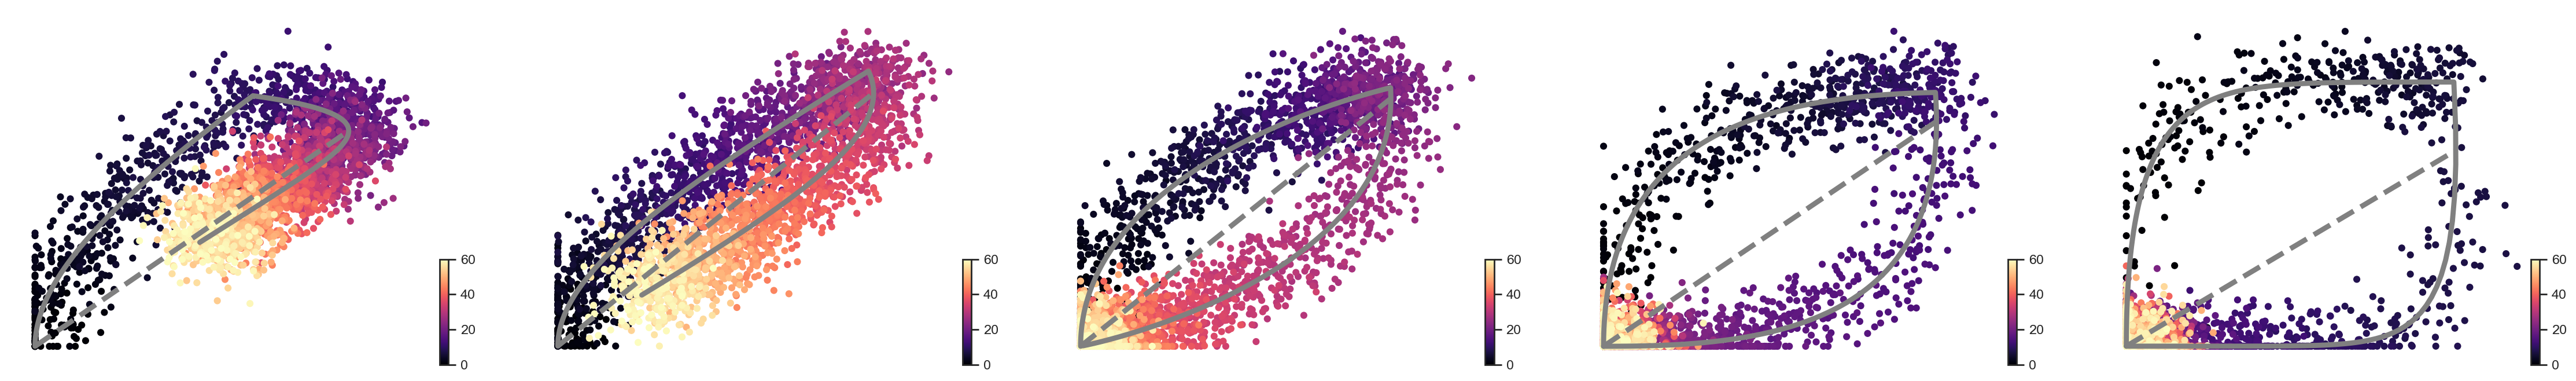

computing neighbors
    finished (0:00:00)
computing velocities
    finished (0:00:00)


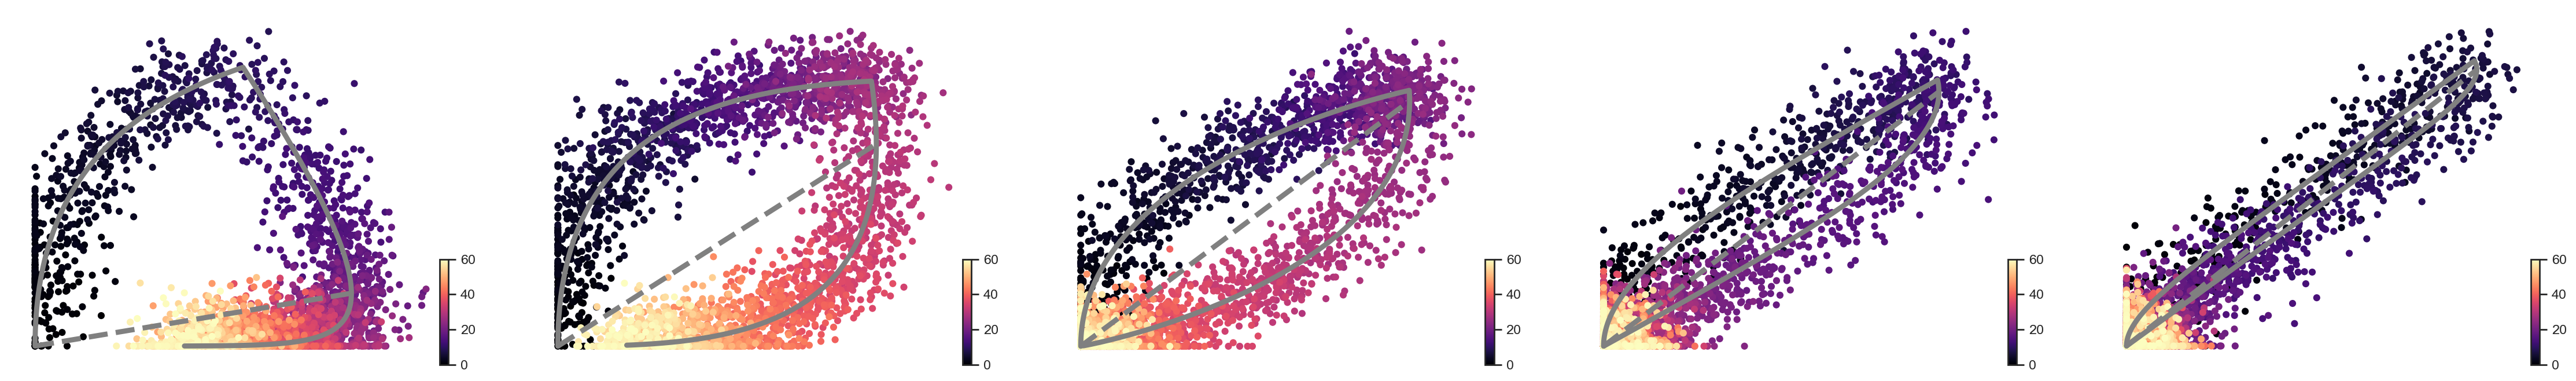

In [18]:
# Generate Parameters
n_vars = 2000

mu = np.array([5, .2, .05])

R = np.array([[1., .2, .2], 
              [.2, 1., .8],
              [.2, .8, 1.]])

C = np.array([.4, .4, .4])[:, None]

cov = C.dot(C.T) * R

alpha, beta, gamma = np.exp(np.random.multivariate_normal(mu, cov, size=n_vars).T)  # multivariate log-normal
beta /= 3
gamma /= 3

#beta *= 10
#gamma *= 10

# remove outliers
idx = (alpha < np.percentile(alpha, 99)) & (beta < np.percentile(beta, 99)) & (gamma < np.percentile(gamma, 99))
alpha = alpha[idx]
beta = beta[idx]
gamma = gamma[idx]
n_vars = np.sum(idx)
switches = np.random.uniform(.1, .5, size=n_vars)


kwargs = {'use_raw': True, 'linewidth': 8, 'legend_loc': 'none', 'color': 'true_t', 
          'frameon': False, 'color_map': 'magma', 'colorbar': True, 'size': 120, 
          'vkey': ['true_dynamics'], 'title':'', 'fontsize': 14, 'legend_fontsize': 20}


# Vary beta
beta_new = beta[0] * np.array([0.1, 0.3, 1, 3, 10])
bdata = scv.datasets.simulation(n_obs=3000, t_max=60, n_vars=5, switches=switches,
                                alpha=[alpha[0]]*5, beta=beta_new, gamma=[gamma[0]]*5, noise_level=.8)
scv.pp.neighbors(bdata)
scv.tl.velocity(bdata, use_raw=True)
var_names = bdata.var_names[:5]
# scv.tl.recover_dynamics(bdata, var_names=var_names, max_iter=100)
scv.pl.scatter(bdata, basis=var_names, **kwargs)

# Vary gamma
gamma_new = gamma[0] * np.array([0.1, 0.3, 1, 3, 10])
bdata = scv.datasets.simulation(n_obs=3000, t_max=60, n_vars=5, switches=switches,
                                alpha=[alpha[0]]*5, beta=[beta[0]]*5, gamma=gamma_new, noise_level=.8)
scv.pp.neighbors(bdata)
scv.tl.velocity(bdata, use_raw=True)
var_names = bdata.var_names[:5]
# scv.tl.recover_dynamics(bdata, var_names=var_names, max_iter=100)
scv.pl.scatter(bdata, basis=var_names, **kwargs)
